# Bilateral Solver Demo

This notebook demos a barebones Python implementation of the bilateral solver.

In [486]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pylab
import seaborn as sns
import numpy as np
from PIL import Image
from helper_funcs import *
sns.set_style('white')
sns.set_context('notebook')
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'CMRmap'
rcParams['figure.facecolor'] = 'w'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/tedlasai/miniconda3/envs/nerfdark/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['imread', 'pylab', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Load in the input problem

[[[31097]
  [31868]
  [31611]
  ...
  [32382]
  [32639]
  [30840]]

 [[31354]
  [32125]
  [32125]
  ...
  [33667]
  [32639]
  [32125]]

 [[32125]
  [31868]
  [32382]
  ...
  [33924]
  [33667]
  [32382]]

 ...

 [[38036]
  [37779]
  [38036]
  ...
  [41120]
  [40606]
  [38550]]

 [[38036]
  [38550]
  [38036]
  ...
  [40349]
  [38807]
  [36494]]

 [[37265]
  [37779]
  [37522]
  ...
  [38550]
  [35980]
  [34181]]]


Text(0.5, 1.0, 'target')

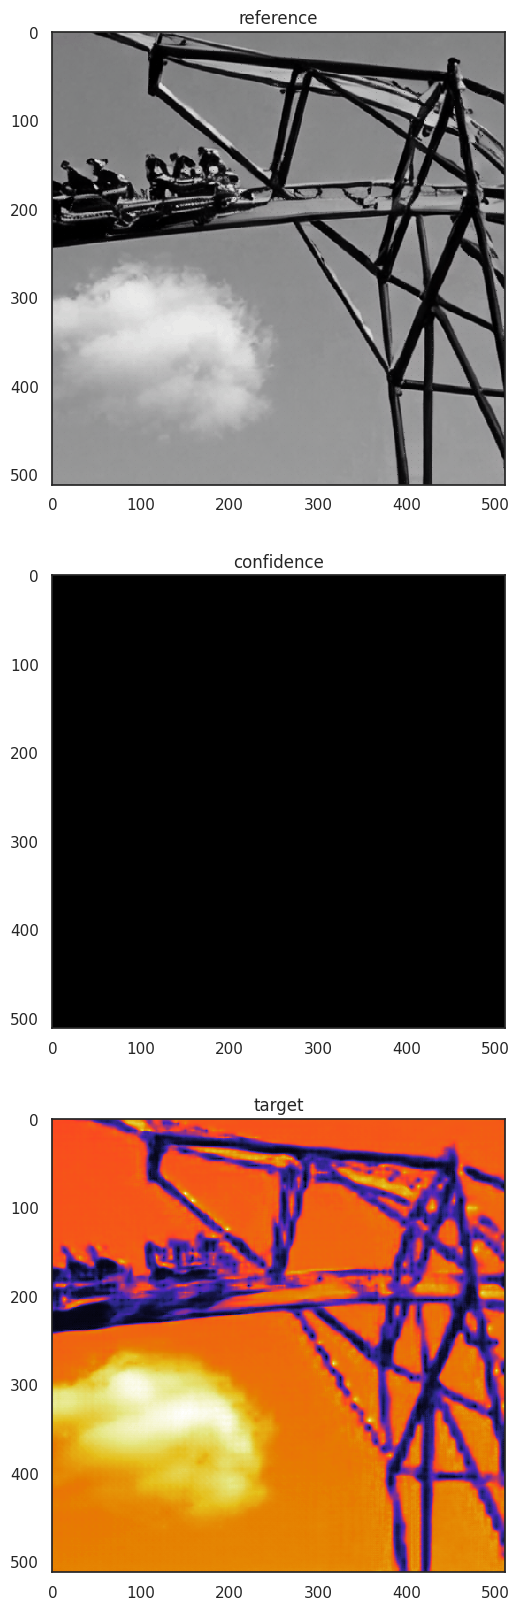

In [ ]:
from skimage.io import imread
import os


import numpy as np
from PIL import Image

def load_image_bilateral(path: str, single_channel: bool = True) -> np.ndarray:
    """
    Load every frame of a GIF and return them in one tensor.

    Parameters
    ----------
    path : str
        Path to the GIF file.
    single_channel : bool, optional
        If True, keep only the red channel; otherwise keep full RGB. Default is True.

    Returns
    -------
    np.ndarray
        * Shape (N, H, W, 1)  if ``single_channel`` is True  
        * Shape (N, H, W, 3)  if ``single_channel`` is False  

        Values are float32 in the range [0, 1].
    """
    with Image.open(path) as im:
        n = getattr(im, "n_frames", 1)  # Pillow≥3.4.0 gives n_frames
        frames = []

        for i in range(n):
            im.seek(i)
            frame = np.asarray(im.convert("RGB"), dtype=np.float32) / 255.0  # H×W×3

            if single_channel:                    # keep dim for easy broadcasting later
                frame = frame[:, :, :1]           # H×W×1 (red channel)

            frames.append(frame)

    return np.stack(frames, axis=0)               # N×H×W×C

def run_bilateral(target, reference):
    """
    Run the bilateral solver on a target image using a reference image.

    Parameters
    ----------
    target : np.ndarray
        The target image to be filtered.
    reference : np.ndarray
        The reference image used for filtering.

    Returns
    -------
    np.ndarray
        The filtered image.
    """
    # Placeholder for the actual bilateral solver implementation
    # For now, just return the target as is
    return target
reference = load_image_bilateral("/home/tedlasai/bilateral_solver/svd-8x8-results/replaced_13.gif", single_channel=False)[0]*255
reference = reference.astype(np.uint16)
#repeat grayscale image to 3 channels

# The 1D image whose values we would like to filter
target = load_image_bilateral("/home/tedlasai/bilateral_solver/svd-8x8-results/stformer_results/video_03.gif")[0]
target = (target*(2**16 - 1)).clip(0,65535).astype(np.uint16)# convert to uint16 # take only one channel
print(target)
# A confidence image, representing how much we trust the values in "target".
# Pixels with zero confidence are ignored.
# Confidence can be set to all (2^16-1)'s to effectively disable it.
confidence = np.ones((target.shape[0], target.shape[1]), dtype=np.uint16) * (2**16 - 1)
im_shape = reference.shape[:2]


assert(im_shape[0] == target.shape[0])
assert(im_shape[1] == target.shape[1])
assert(im_shape[0] == confidence.shape[0])
assert(im_shape[1] == confidence.shape[1])

figure(figsize=(14, 20))
subplot(311)
imshow(reference)
title('reference')
subplot(312)
imshow(confidence)
title('confidence')
subplot(313)
imshow(target)
title('target')

## Set parameters

In [488]:
grid_params = {
    'sigma_luma' : 4, # Brightness bandwidth
    'sigma_chroma': 100, # Color bandwidth
    'sigma_spatial': 8 # Spatial bandwidth
}

bs_params = {
    'lam': 128, # The strength of the smoothness parameter
    'A_diag_min': 1e-5, # Clamp the diagonal of the A diagonal in the Jacobi preconditioner.
    'cg_tol': 1e-5, # The tolerance on the convergence in PCG
    'cg_maxiter': 25 # The number of PCG iterations
}

grid = BilateralGrid(reference, **grid_params)

t = target.reshape(-1, 1).astype(np.double) / (pow(2,16)-1)
c = confidence.reshape(-1, 1).astype(np.double) / (pow(2,16)-1)
tc_filt = grid.filter(t * c)
c_filt = grid.filter(c)
output_filter = (tc_filt / c_filt).reshape(im_shape)
output_solver = BilateralSolver(grid, bs_params).solve(t, c).reshape(im_shape)

/tmp/ipykernel_1229941/1015436917.py:42: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  yhat[..., d], info = cg(A, b[..., d], x0=y0[..., d], M=M, maxiter=self.params["cg_maxiter"], tol=self.params["cg_tol"])


## Visualize the output

Text(0.5, 1.0, 'bilateral solver')

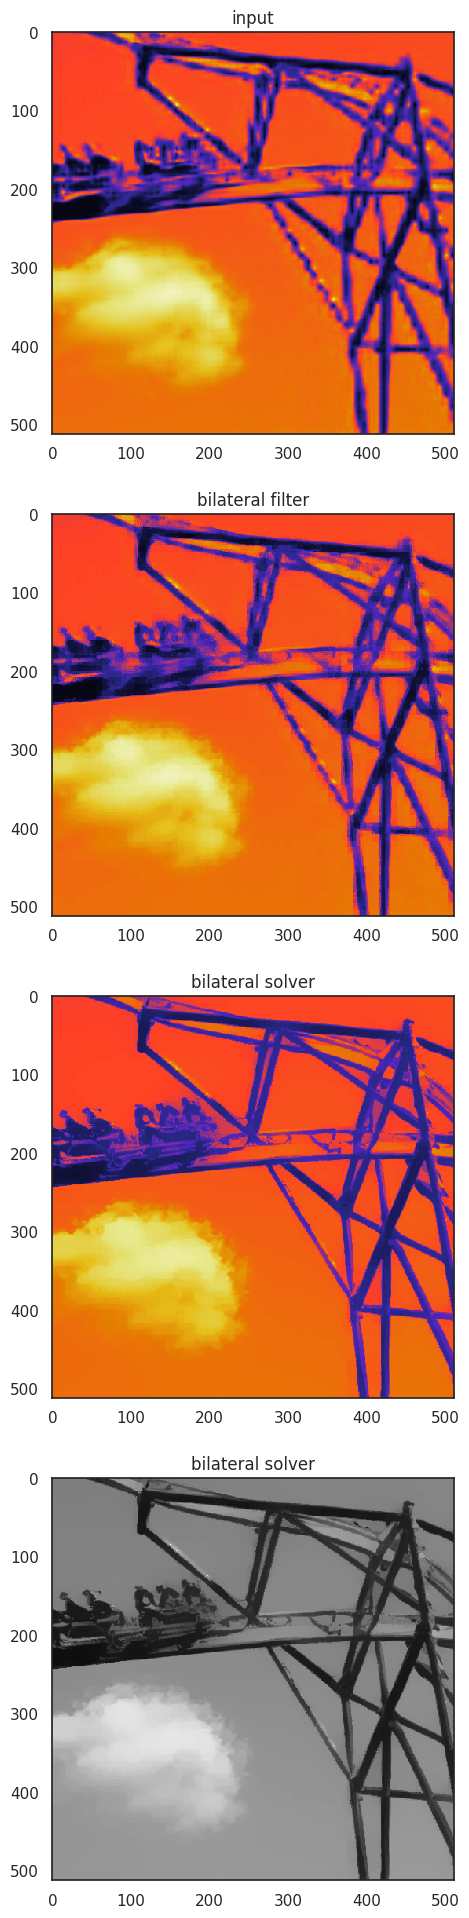

In [489]:
imargs = dict(vmin=0, vmax=1)
figure(figsize=(14, 24))
subplot(411)
imshow(t.reshape(im_shape), **imargs)
title('input')
subplot(412)
imshow(output_filter, **imargs)
title('bilateral filter')
subplot(413)
imshow(output_solver, **imargs)
title('bilateral solver')
subplot(414)
imshow(output_solver, cmap='gray', **imargs)
title('bilateral solver')

In [ ]:


# error_solver =  np.abs(gt - output_solver)
# error_input = np.abs(gt - reference)
# error_stformer = np.abs(gt - stformer)
# #show error
# figure(figsize=(14, 24))
# subplot(411)
# imshow(error_input, **imargs)
# title('input error')
# subplot(412)
# imshow(error_solver, **imargs)
# title('bilateral solver error')
# subplot(413)
# imshow(error_stformer, **imargs)
# title('stformer error')

def psnr(img1: np.ndarray, img2: np.ndarray, max_val: float = 1.0) -> float:
    """
    Compute PSNR between two images.

    Parameters
    ----------
    img1, img2 : np.ndarray
        Input images. Must have the same shape.
    max_val : float, default 1.0
        The maximum possible pixel value (e.g., 255 for uint8, 1.0 for normalized float).

    Returns
    -------
    float
        PSNR value in decibels (dB).
    """
    assert img1.shape == img2.shape, "Images must have the same shape"
    mse_val = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    if mse_val == 0:
        return float('inf')  # Perfect match
    return 10 * np.log10((max_val ** 2) / mse_val)



psnrs_reference = []
#psnrs_solver = []
psnrs_stformer = []

#compare to original
gt = load_image_bilateral("/home/tedlasai/bilateral_solver/svd-8x8-results/gt_13.gif")
reference = load_image_bilateral("/home/tedlasai/bilateral_solver/svd-8x8-results/replaced_13.gif")
stformer = load_image_bilateral("/home/tedlasai/bilateral_solver/svd-8x8-results/stformer_results/video_03.gif")

num_frames = gt.shape[0]
for i in range(num_frames):

    psnrs_reference.append(psnr(gt[i], reference[i]))
    psnrs_stformer.append(psnr(gt[i], stformer[i]))

print("PSNRs Reference: ", psnrs_reference)
print("PSNRs stformer: ", psnrs_stformer)
psnr_reference = np.mean(psnrs_reference)
#psnr_solver = np.mean(psnrs_solver)
psnr_stformer = np.mean(psnrs_stformer)

print("PSNR input: ", psnr_reference)
#print("PSNR solver: ", psnr_solver)
print("PSNR stformer: ", psnr_stformer)

PSNRs Reference:  [21.770531171241203, 21.876213281929388, 21.87743177906694, 21.763774636683195, 21.81594481069947, 21.993147829326723, 21.70911626186516, 21.719805470784355, 21.51956880954026, 21.59933151379613, 21.829295877480437, 21.70207623561394, 21.20919781647807, 21.290771011845067, 21.18341485031399, 21.15124187019123, 21.130528619281286, 21.36024321193473, 21.143687027795963, 20.96632413662217, 21.14060412700909, 21.143820716140418, 20.981473533095524, 21.15532858689685, 21.11883760498072, 21.24520889003412, 21.10440669505096, 21.23527721041793, 20.988646291385336, 20.8735915703469, 20.861762805181257, 21.028339096899412, 20.946085089604686, 21.116719194805253, 21.185398657351612, 21.432036499207925, 21.646547510380614, 21.683358136409588, 21.68242227529646, 21.652685448227153, 21.473094604945327, 21.634890738596976, 21.313073772417376, 21.321542627124845, 21.530634042042998, 21.481151178432487, 21.44884251964048, 21.371377750689135, 21.355487175940514, 21.08942811860855, 20.